Kickstarter　様々な手法で解いてみた

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

kaggleのkickstarterデータセットを使用

In [2]:
df_kick=pd.read_csv("ks-projects-201801.csv")

In [3]:
print(df_kick.head())
print("{}/n".format(df_kick.head()))
print(df_kick.isnull().sum())
print(df_kick.info())
print(df_kick["state"].value_counts())

           ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   

         category main_category currency    deadline     goal  \
0          Poetry    Publishing      GBP  2015-10-09   1000.0   
1  Narrative Film  Film & Video      USD  2017-11-01  30000.0   
2  Narrative Film  Film & Video      USD  2013-02-26  45000.0   
3           Music         Music      USD  2012-04-16   5000.0   
4    Film & Video  Film & Video      USD  2015-08-29  19500.0   

              launched  pledged     state  backers country  usd pledged  \
0  2015-08-11 12:12:28      0.0    failed        0      GB          0.0   
1  2017-09-02 04:43:57   2421.0    failed       15

データ整理

In [4]:
#目的変数を少なくする
df_kick_success = df_kick[df_kick['state']=='successful']
df_kick_fail =  df_kick[df_kick['state']=='failed']
#df_kick_cancel=df_kick[df_kick['state']=="canceled"]
#df_kick_cancel["state"]="failed"
df_state = pd.concat([df_kick_success,df_kick_fail])
df_kickdna = df_state.dropna(how='any')
le = LabelEncoder()
le = le.fit(df_kickdna['category'])
df_kickdna['category1'] = le.transform(df_kickdna['category'])
le = le.fit(df_kickdna['main_category'])
df_kickdna['main_category1'] = le.transform(df_kickdna['main_category'])
le = le.fit(df_kickdna['currency'])
df_kickdna['currency1'] = le.transform(df_kickdna['currency'])
le = le.fit(df_kickdna['state'])
df_kickdna['state1'] = le.transform(df_kickdna['state'])
le = le.fit(df_kickdna['country'])
df_kickdna['country1'] = le.transform(df_kickdna['country'])

C:\Users\uedan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\uedan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\uedan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [5]:
print("{} \n{}".format(df_kickdna.head(),df_kickdna["state"].value_counts()))

            ID                                               name  \
5   1000014025                               Monarch Espresso Bar   
6   1000023410  Support Solar Roasted Coffee & Green Energy!  ...   
11   100005484                                   Lisa Lim New CD!   
14  1000057089  Tombstone: Old West tabletop game and miniatur...   
18  1000070642                Mike Corey's Darkness & Light Album   

          category main_category currency    deadline     goal  \
5      Restaurants          Food      USD  2016-04-01  50000.0   
6             Food          Food      USD  2014-12-21   1000.0   
11      Indie Rock         Music      USD  2013-04-08  12500.0   
14  Tabletop Games         Games      GBP  2017-05-03   5000.0   
18           Music         Music      USD  2012-08-17    250.0   

               launched  pledged       state  backers country  usd pledged  \
5   2016-02-26 13:38:27  52375.0  successful      224      US     52375.00   
6   2014-12-01 18:30:44   1205.0

日付データから、クラウドファンディングが開催されている期間を得る

In [6]:
import datetime
from datetime import timedelta
jikan=df_kickdna['launched'].str.split(' ', expand=True)
jikan.rename(columns={0: 'tosi', 1: 'jikan'}, inplace=True)
jikan.drop("jikan",axis=1,inplace=True)
df_hiniti = pd.concat([jikan,df_kickdna["deadline"]],axis=1)
df_hiniti["Datelaunch"]=pd.to_datetime(df_hiniti["tosi"])
df_hiniti["Datedead"]=pd.to_datetime(df_hiniti["deadline"])
df_hiniti["kikan"]=df_hiniti["Datedead"]-df_hiniti["Datelaunch"]
df_hiniti["kikan_float"] = (df_hiniti["kikan"] / timedelta(days=1))
df_hiniti["kikan_int"] = df_hiniti["kikan_float"].astype("int")
print(df_hiniti.head())
jikankai=jikan["tosi"].str.split("-",expand=True)
jikankai.rename(columns={0: 'year', 1: 'tuki',2:'hizuke'}, inplace=True)
deadline=df_kickdna['deadline'].str.split('-', expand=True)
deadline.rename(columns={0: 'deadtosi', 1: 'deadjikan',2:'deadhizuke'}, inplace=True)
df_hiniti1 = pd.concat([jikankai,deadline],axis=1)
df_hiniti_int=df_hiniti1.astype('int')
print(df_hiniti_int.head())
aaa=df_hiniti.drop(["tosi","deadline","Datelaunch","Datedead","kikan","kikan_float"],axis='columns')
bbb=df_hiniti_int.drop(["hizuke","deadhizuke"],axis="columns")

hiniti_cmp=pd.concat([bbb,aaa],axis=1)
print(hiniti_cmp.head())
#df_hiniti_int.loc[df_hiniti_int["hizuke"]>15,"tuki"]+=1
#df_hiniti_int.loc[df_hiniti_int["deadhizuke"]>15,"deadjikan"]+=1
#df_hiniti_int.loc[df_hiniti_int["tuki"]>12,"tosi"]+=1
#df_hiniti_int.loc[df_hiniti_int["tuki"]>12,"tuki"]-=12
#df_hiniti_int.loc[df_hiniti_int["deadjikan"]>12,"deadtosi"]+=1
#df_hiniti_int.loc[df_hiniti_int["deadjikan"]>12,"deadjikan"]-=12
#df_hiniti_int["kikan"]=df_hiniti_int["deadjikan"]-df_hiniti_int["tuki"]+12*(df_hiniti_int["deadtosi"]-df_hiniti_int["tosi"])
#print(df_hiniti.head())
#print(df_hiniti_int.head())
#print(df_hiniti_int["kikan"].value_counts())
#print(df_hiniti_int.groupby("kikan").get_group(485))

          tosi    deadline Datelaunch   Datedead   kikan  kikan_float  \
5   2016-02-26  2016-04-01 2016-02-26 2016-04-01 35 days         35.0   
6   2014-12-01  2014-12-21 2014-12-01 2014-12-21 20 days         20.0   
11  2013-03-09  2013-04-08 2013-03-09 2013-04-08 30 days         30.0   
14  2017-04-05  2017-05-03 2017-04-05 2017-05-03 28 days         28.0   
18  2012-08-02  2012-08-17 2012-08-02 2012-08-17 15 days         15.0   

    kikan_int  
5          35  
6          20  
11         30  
14         28  
18         15  
    year  tuki  hizuke  deadtosi  deadjikan  deadhizuke
5   2016     2      26      2016          4           1
6   2014    12       1      2014         12          21
11  2013     3       9      2013          4           8
14  2017     4       5      2017          5           3
18  2012     8       2      2012          8          17
    year  tuki  deadtosi  deadjikan  kikan_int
5   2016     2      2016          4         35
6   2014    12      2014         12

不必要なデータをなくす

In [7]:
print(df_kickdna.head())
dropdata=df_kickdna.drop(["ID","name","category","main_category","state","currency","deadline","launched","country","backers","usd pledged","usd_pledged_real","usd_goal_real","pledged"],axis=1)
print(dropdata.head())

            ID                                               name  \
5   1000014025                               Monarch Espresso Bar   
6   1000023410  Support Solar Roasted Coffee & Green Energy!  ...   
11   100005484                                   Lisa Lim New CD!   
14  1000057089  Tombstone: Old West tabletop game and miniatur...   
18  1000070642                Mike Corey's Darkness & Light Album   

          category main_category currency    deadline     goal  \
5      Restaurants          Food      USD  2016-04-01  50000.0   
6             Food          Food      USD  2014-12-21   1000.0   
11      Indie Rock         Music      USD  2013-04-08  12500.0   
14  Tabletop Games         Games      GBP  2017-05-03   5000.0   
18           Music         Music      USD  2012-08-17    250.0   

               launched  pledged       state  backers country  usd pledged  \
5   2016-02-26 13:38:27  52375.0  successful      224      US     52375.00   
6   2014-12-01 18:30:44   1205.0

外れ値の削除

In [8]:
kickdata_cmp=pd.concat([dropdata,hiniti_cmp],axis=1)
#print(kickdata_cmp.describe())
#print(kickdata_cmp.info())
#print(kickdata_cmp["goal"].value_counts())
#外れ値の削除
kickdata_cmp.drop(kickdata_cmp.loc[kickdata_cmp['year']==1970].index, inplace=True)
q1= kickdata_cmp["goal"].quantile(0.25)
q2= kickdata_cmp["goal"].quantile(0.75)
iqr=q2-q1
max= q2+1.5*(iqr)#範囲指定max
min= q1-1.5*(iqr)#範囲指定min
kickdata_cmp.drop(kickdata_cmp.loc[kickdata_cmp['goal']>max].index, inplace=True)
kickdata_cmp.drop(kickdata_cmp.loc[kickdata_cmp['goal']<min].index, inplace=True)
#print(kickdata_cmp["goal"].value_counts())

#from sklearn.preprocessing import StandardScaler
#stdsc = StandardScaler()
#kickdata_cmp["goal"] = stdsc.fit_transform(kickdata_cmp[["goal"]].values)
#kickdata_cmp["kikan_int"] = stdsc.fit_transform(kickdata_cmp[["kikan_int"]].values)

#年のデータは必要ないと思ったので落とす
xx=kickdata_cmp.drop(["state1","year","deadtosi"],axis=1)
y=kickdata_cmp["state1"]
X= xx.astype('float64')
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290598 entries, 6 to 378660
Data columns (total 8 columns):
goal              290598 non-null float64
category1         290598 non-null float64
main_category1    290598 non-null float64
currency1         290598 non-null float64
country1          290598 non-null float64
tuki              290598 non-null float64
deadjikan         290598 non-null float64
kikan_int         290598 non-null float64
dtypes: float64(8)
memory usage: 20.0 MB
None


標準化

In [9]:

X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=1234)
print(X_train.info())
#print(y_train.head())
#標準化を行う
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train["goal"] = stdsc.fit_transform(X_train[["goal"]].values)
X_test["goal"]=stdsc.transform(X_test[["goal"]].values)
X_train["category1"] = stdsc.fit_transform(X_train[["category1"]].values)
X_test["category1"]=stdsc.transform(X_test[["category1"]].values)
X_train["main_category1"] = stdsc.fit_transform(X_train[["main_category1"]].values)
X_test["main_category1"]=stdsc.transform(X_test[["main_category1"]].values)
X_train["currency1"] = stdsc.fit_transform(X_train[["currency1"]].values)
X_test["currency1"]=stdsc.transform(X_test[["currency1"]].values)
X_train["country1"] = stdsc.fit_transform(X_train[["country1"]].values)
X_test["country1"]=stdsc.transform(X_test[["country1"]].values)
X_train["tuki"] = stdsc.fit_transform(X_train[["tuki"]].values)
X_test["tuki"]=stdsc.transform(X_test[["tuki"]].values)
X_train["deadjikan"] = stdsc.fit_transform(X_train[["deadjikan"]].values)
X_test["deadjikan"]=stdsc.transform(X_test[["deadjikan"]].values)
X_train["kikan_int"] = stdsc.fit_transform(X_train[["kikan_int"]].values)
X_test["kikan_int"]=stdsc.transform(X_test[["kikan_int"]].values)
print(X_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232478 entries, 162421 to 314757
Data columns (total 8 columns):
goal              232478 non-null float64
category1         232478 non-null float64
main_category1    232478 non-null float64
currency1         232478 non-null float64
country1          232478 non-null float64
tuki              232478 non-null float64
deadjikan         232478 non-null float64
kikan_int         232478 non-null float64
dtypes: float64(8)
memory usage: 16.0 MB
None


C:\Users\uedan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\uedan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\uedan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

            goal  category1  main_category1  currency1  country1      tuki  \
162421 -0.293403  -0.911260       -0.354974   0.483712  0.474053  0.482873   
302648 -0.293403   0.139042        0.655725   0.483712  0.474053  0.180535   
306677 -0.821090   0.653020        0.655725  -1.606929 -1.616352  0.785212   
142461  2.345030   0.742407       -0.860323   0.483712  0.474053 -0.726481   
372412  0.366205   1.099957       -0.354974   0.483712  0.474053 -0.121804   

        deadjikan  kikan_int  
162421   0.982054   1.306425  
302648   0.076058  -1.850561  
306677   1.284053   1.701048  
142461  -0.527940   0.911801  
372412   0.076058  -0.272068  


C:\Users\uedan\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\uedan\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


データの可視化

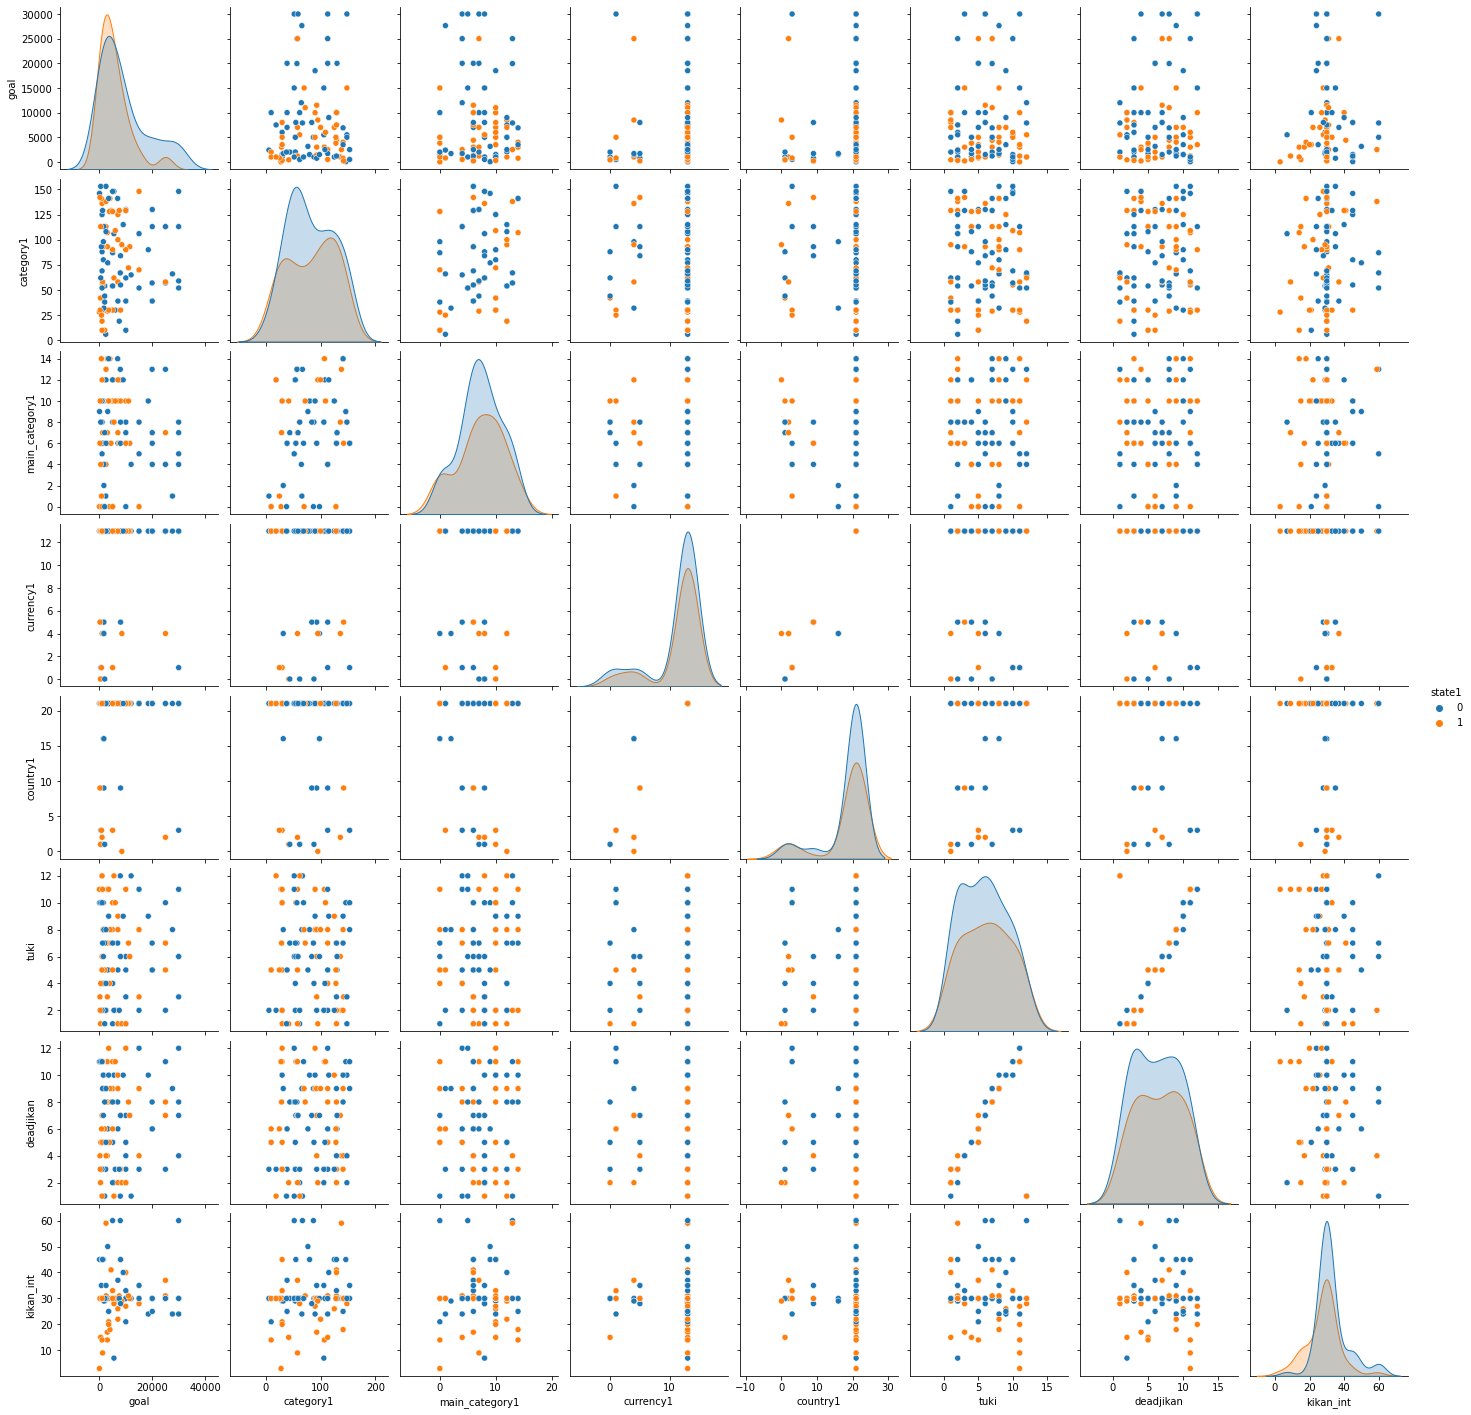

In [10]:
X_trainsns,X_testsns,y_trainsns,y_testsns,= train_test_split(X,y,stratify=y,test_size=100,random_state=1234)
ccc=pd.concat([X_testsns,y_testsns],axis=1)
g = sns.pairplot(ccc,hue="state1")                           # ペアプロットをするデータを定義
plt.show() 

ロジスティック回帰

In [11]:
#パラメータチューニングする前のロジスティック回帰
clf = SGDClassifier(loss = "log", penalty = "L2",random_state=1234,tol=1e-3,max_iter=1000)
clf.fit(X_train,y_train)
clf.score(X_test, y_test)

0.5914143152099105

In [12]:
#グリッドサーチした後のロジスティック回帰
parameters = {'penalty':['l1', 'l2'], 'alpha':[0.0001,0.001, 0.01, 0.1, 1, 10, 100]} # ここを編集する
model = SGDClassifier(random_state=1234,tol=1e-3,max_iter=1000)
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(X_train, y_train)
clf_1 = SGDClassifier(**clf.best_params_,loss = "log",random_state=1234)
clf_1.fit(X_train, y_train)
print(clf_1.score(X_test, y_test))
print(clf.best_params_)

C:\Users\uedan\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.5816586373021335
{'alpha': 0.0001, 'penalty': 'l1'}


アダブースト

In [13]:
#パラメータチューニングする前のアダブースト
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,
                                                                                 min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=20, random_state=1234)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.6555230557467309


In [14]:
#まず、決定木に対してグリッドサーチ
parameters = {'max_depth':[2,3,4,5], 'min_samples_leaf':[1,2,3],'min_samples_split':[2,3,4],"criterion":["gini","entropy"]}
model = DecisionTreeClassifier(random_state=1234)
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.best_params_)

0.6103062629043359
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}


In [15]:
#パラメータチューニングした後のアダブースト
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,
                                                                                 min_samples_leaf=3,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=20, random_state=1234)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.6617171369580179


交差検証

In [16]:
#Kfoldもやってみる
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_pre = 0
split_num = 1
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train1, y_train1 = X.iloc[train_idx], y.iloc[train_idx] #学習用データ
    X_test1, y_test1 = X.iloc[test_idx], y.iloc[test_idx]     #テスト用データ
    
    # 学習用データを使ってモデルを決定木（アダブースト）を学習
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,
                                                                                 min_samples_leaf=3,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=20, random_state=1234)
    clf.fit(X_train1, y_train1)

    # テストデータに対する予測を実行
    y_pred_test = clf.predict(X_test1)
    
    # テストデータに対するMAEを計算
    pre = precision_score(y_test1, y_pred_test)
    print("Fold %s"%split_num)
    print("pre = %s"%round(pre, 3))
    print()
    
    cross_valid_pre += pre #後で平均を取るためにseidoを加算
    split_num += 1

# seidoの平均値を最終的な汎化誤差値とする
final_pre = cross_valid_pre / n_split
print("Cross Validation PRE = %s"%round(final_pre, 3))

Fold 1
pre = 0.625

Fold 2
pre = 0.637

Fold 3
pre = 0.63

Fold 4
pre = 0.63

Fold 5
pre = 0.626

Cross Validation PRE = 0.63


tensorflowでの予測

In [17]:
from sklearn.metrics import confusion_matrix
from tensorflow import keras  
import tensorflow as tf

In [18]:
print(kickdata_cmp["state1"].value_counts())

0    164192
1    126406
Name: state1, dtype: int64


In [19]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_test)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 232478 samples, validate on 58120 samples
Epoch 1/50
232478/232478 [==============================] - 13s 54us/sample - loss: 0.6679 - acc: 0.5879 - val_loss: 0.6682 - val_acc: 0.5899
Epoch 2/50
232478/232478 [==============================] - 13s 54us/sample - loss: 0.6658 - acc: 0.5915 - val_loss: 0.6678 - val_acc: 0.5878
Epoch 3/50
232478/232478 [==============================] - 13s 55us/sample - loss: 0.6655 - acc: 0.5924 - val_loss: 0.6677 - val_acc: 0.5872
Epoch 4/50
232478/232478 [==============================] - 12s 52us/sample - loss: 0.6647 - acc: 0.5928 - val_loss: 0.6663 - val_acc: 0.5912
Epoch 5/50
232478/232478 [==============================] - 12s 50us/sample - loss: 0.6642 - acc: 0.5930 - val_loss: 0.6662 - val_acc: 0.5907
Epoch 6/50
232478/232478 [==============================] - 12s 52us/sample - loss: 0.6641 - acc: 0.5937 - val_loss: 0.66

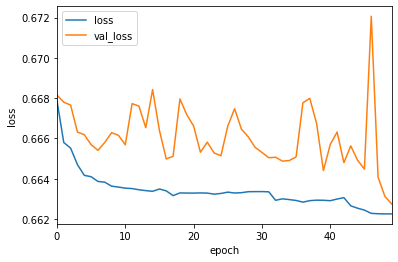

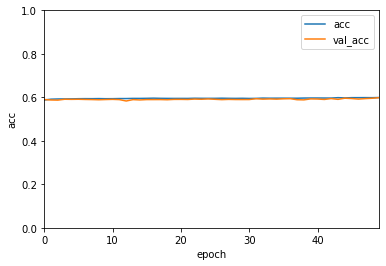

In [20]:
model = Sequential()
model.add(Dense(6, activation='relu', input_dim=8))
model.add(Dense(5, activation='relu', input_dim=6))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=50,
          batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()